# How Does Dengo Generate Solvers?

This tutorial tells you how the solver are generated with the help of `dengo.ChemicalNetwork`, and `Jinja2`. In short, `dengo.ChemicalNetwork` carries the full information of the chemical reactions and cooling actions of interest. It internally generates the symbolic representation of the dynamics of each chemical species. This can be exported as `C++` or `python` code with a pre-written templates which can be found under `dengo/templates`. In this example we will be demonstrating how to generate rhs and solve the initial value problem with`scipy.odeint`

## Import Libraries and Create the Network

Primordial rates and cooling for the 9-species network are included in the default dengo library in `dengo.primordial_rates` and `dengo.primordial_cooling`. The reactions and cooling are added automatically to the `reaction_registry`, `cooling_registry` and `species_registry` with the call to `dengo.primordial_rates.setup_primordial`. 

Here we setup the same sample network we demonstrated in the last chapter with `k01`, `k02` and `reHII`.

In [204]:
import dengo
from dengo.chemical_network import \
 ChemicalNetwork, \
 reaction_registry, \
 cooling_registry, species_registry
import dengo.primordial_rates
import dengo.primordial_cooling

dengo.primordial_rates.setup_primordial()

simpleNetwork = ChemicalNetwork()
simpleNetwork.add_reaction("k01")
simpleNetwork.add_reaction("k02")
simpleNetwork.add_cooling("reHII")
simpleNetwork.init_temperature((1e0, 1e8))

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1


## Building the solver
In this example, we will walk you through how to write a template from scratch that can be fed into a scipy solver. This can be done with `ChemicalNetwork.write_solver` and the combination of templates available under `dengo/templates`.

### Evaluate the reaction rates
Reaction rates usually have a temperature dependence. For example, for reactions following the [Arrhenius equation](https://en.wikipedia.org/wiki/Arrhenius_equation) usually have the forms of $k(T) = A e^{-\frac{E_a}{RT}}$, where $k$ is the reaction rate, $E_a$ is the activation energy of the reaction, $T$ is the temperature, $A$, $R$ are the pre-exponential factor, and the universal gas constant respectively. $A$ is sometimes depends further on temperature in [Modified Arrhenius equation](https://en.wikipedia.org/wiki/Arrhenius_equation#Modified_Arrhenius_equation).

Evaluating these rates on the fly would be computationally expensive. One possible way of reducing the computational time is to interpolate from a pre-calculated reaction rates table. The rates are specified when the reactions `rxn` are first created with the `@reaction` decorator. They can be evaluated handily with `rxn.coeff_fn(chemicalnetwork)`. The range of temperature of interest for example $T = \rm (1, 10^8) K$ can be first specified with `ChemicalNetwork.init_temperature(T_bounds=(1e0, 1e8), n_bins=1024)`. The added reaction objects can be accessed with `ChemicalNetwork.reactions`. For example, the reaction rates of `k01` can the accessed with the snippet below
```python
rxn_rate = cn.reactions['k01'].coeff_fn(ChemicalNetwork)
```
The output `rxn_rate` is an numpy array with a length of `[n_bins]`.

A reaction rate table is generated and exported to a `hdf5` file below.



```python
with h5py.File(ofn, 'r') as f:
    print(f.keys())
>>> <KeysViewHDF5 ['T', 'k01', 'k02', 'reHII_reHII']>
```

In [65]:
import os
import h5py

solver_name = 'simple'
output_dir  = "."

ofn = os.path.join(output_dir, f"{solver_name}_tables.h5")

if os.path.exists(ofn):
    os.system(f"rm {ofn}")

with h5py.File(ofn, 'w') as f:
    for rxn in sorted(simpleNetwork.reactions.values()):
        f.create_dataset(
            f"/{rxn.name}", data=rxn.coeff_fn(simpleNetwork).astype("float64")
        )

    for rxn in sorted(simpleNetwork.cooling_actions.values()):
        if hasattr(rxn, "tables"):
            for tab in rxn.tables:
                f.create_dataset(
                    f"/{rxn.name}_{tab}",
                    data=rxn.tables[tab](simpleNetwork).astype("float64"),
                )
    f.create_dataset(f"/T", data=simpleNetwork.T.astype("float64"))

## Using `Jinja2`

`Jinja2` fills out variables dynamically with the user-given inputs. It is however not limited to variables subsitution. You can also use conditions (if/else), for loops (for), filter, and tests in Jinja2 template. To construct our solver template for `scipy`, we will be using for-loop, if-else, and variable substitution. And we will go through these usages briefly below their respective syntax. We refer our readers for more details in [Jinja2 Documentation](http://jinja.octoprint.org/).

For example if the template is `Dengo {{token}}`, Jinja2 would look for the user-fed input for the variable `token`, and output the file with the word in curly bracket replaced with the `token = "works"`.




In [68]:
from jinja2 import Template
t = Template("Dengo {{ token }}!")
print(t.render(token="works"))

Dengo works!


Jinja2 also provided an straightforward way to iterate over iterables like lists, with the syntax `{% for item in list %} {% endfor %}`. In the example below, we iterate over the required species in our chemical network, and had Jinja2 print out their name.

In [71]:
t = Template("""
{% for s in network.required_species | sort %}
{{s.name}},
{% endfor %}
""")
print(t.render(network = simpleNetwork))



H_1,

H_2,

de,

ge,



### Preparing the rates interpolation template
In the template below, we demonstrate a simple implementation for interpolating reaction and cooling rates with `Jinja2` and our `ChemicalNetwork` object. In brief, the template below first reads in the rates from the `hdf5` we created above, and two functions `interpolate_rates` and `interpolate_cooling_rates` are created dynamically based on the reactions avaiable in our `ChemicalNetwork`.

In [126]:
reaction_rates_template = Template("""
import numpy as np
import h5py

# read rates in as global variables
rates_table = "{{solver_name}}_tables.h5"
ratef = h5py.File(rates_table, 'r')

# Reaction Rates
{% for k in network.reactions.keys()%}
out{{k}}dev = ratef['{{k}}'][:]
{%- endfor %} 

# Cooling Rates
{%- for name, rate in network.cooling_actions | dictsort %}
{%- for name2 in rate.tables | sort %}
out_{{name}}_{{name2}} = ratef["{{name}}_{{name2}}"][:]
{%- endfor %}
{%- endfor %}
tdev = ratef['T'][:]
ratef.close()

def interpolate_rates(T):
    {% for k in network.reactions.keys()%}
    {{k}} = np.interp(T, tdev, out{{k}}dev)
    {%- endfor %} 
    return (
    {%- for k in network.reactions.keys() -%}
    {{k}}, 
    {%- endfor -%}
    )
def interpolate_cooling_rates(T):
    {%- for name, rate in network.cooling_actions | dictsort %}
    {%- for name2 in rate.tables | sort %}
    {{name}}_{{name2}} = np.interp(T, tdev, out_{{name}}_{{name2}})
    {%- endfor %}
    {%- endfor %}
    return (
    {%- for name, rate in network.cooling_actions | dictsort -%}
    {%- for name2 in rate.tables | sort -%}
    {{name}}_{{name2}}, 
    {%- endfor -%}
    {%- endfor -%}
    )
    """)

template_vars = dict(
    network=simpleNetwork, 
    solver_name=solver_name
)
output_file = f'{solver_name}_reaction_rate.py'
with open(output_file, 'w') as f:
    f.write(reaction_rates_template.render(template_vars))

### Import the Rendered `simple_reaction_rate.py` and Check if it works!

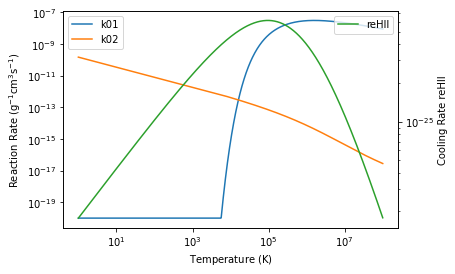

In [131]:
from simple_reaction_rate import interpolate_rates, interpolate_cooling_rates
import matplotlib.pyplot as plt

temperature = simpleNetwork.T
rxnk01_rate, rxnk02_rate = interpolate_rates(temperature)
coolreHII_rate,          = interpolate_cooling_rates(temperature)

plt.loglog(temperature, rxnk01_rate, label='k01')
plt.loglog(temperature, rxnk02_rate, label='k02')
plt.xlabel(r'Temperature $(\rm K)$')
plt.ylabel(r'Reaction Rate $(\rm g^{-1} cm^{3} s^{-1} )$')
plt.legend()
ax2 = plt.twinx()
ax2.loglog(temperature, coolreHII_rate,color='C2', label='reHII')
plt.ylabel(r'Cooling Rate reHII')
plt.legend()

# Implement the temperature function

```jinja2
gamma = 5./3.
kb    = 1.38e-16
mh    = 1.67e-24

def calculate_temperature(state: npt.ArrayLike):
    # extract the abundance from the state vector
    {% for s in network.required_species | sort -%}
    {{s.name}}, 
    {%- endfor -%}
    = state
    density = {{network.print_mass_density()}}
    T = {{network.temperature_calculation()}}
    return T
```

In [205]:
temperature_template = Template("""
import numpy as np
gamma = 5./3.
kb    = 1.38e-16
mh    = 1.67e-24

def calculate_temperature(state):
    # extract the abundance from the state vector
    {% for s in network.required_species | sort -%}
    {{s.name}}, 
    {%- endfor -%}
    = state
    density = {{network.print_mass_density()}}
    T = {{network.temperature_calculation()}}
    return T
    

""")
output_file = f'{solver_name}_temperature.py'
with open(output_file, 'w') as f:
    f.write(temperature_template.render(network =simpleNetwork))

In [206]:
# %load simple_temperature.py

gamma = 5./3.
kb    = 1.38e-16
mh    = 1.67e-24

def calculate_temperature(state):
    # extract the abundance from the state vector
    H_1,H_2,de,ge,= state
    density = 1.0079400000000001*H_1 + 1.0079400000000001*H_2
    T = density*ge*mh/(kb*(H_1/(gamma - 1.0) + H_2/(gamma - 1.0) + de/(gamma - 1.0)))
    return T
    


In [207]:
# from simple_temperature import calculate_temperature
import numpy  as np
# Prepare the initial state vector
ge = 1e13  #erg/g
H_1 = 1e-2# 1/cm^3
H_2 = 1e-2# 1/cm^3
de  = 1e-2# 1/cm^3
state = np.array([H_1, H_2, de, ge])
simple_temperature.calculate_temperature(state)

54211.26570048309

### Implement the RHS function

In [208]:
rhs_template = Template("""
import numpy as np
from {{solver_name}}_temperature import calculate_temperature
from {{solver_name}}_reaction_rate import interpolate_rates, interpolate_cooling_rates
mh    = 1.67e-24

def rhs_func(state, t):

    # extract the abundance from the state vector
    {% for s in network.required_species | sort -%}
    {{s.name}}, 
    {%- endfor -%}
    = state
    
    T   = calculate_temperature(state)[np.newaxis]
    
    {% for k in network.reactions.keys() -%}
    {{k}}, 
    {%- endfor -%}
    = interpolate_rates    (T)
    
    i = 0
    
    {% for name, rate in network.cooling_actions | dictsort -%}
    {%- for name2 in rate.tables | sort -%}
    {{name}}_{{name2}}, 
    {%- endfor -%}
    {%- endfor -%}
    = interpolate_cooling_rates(T)
    
    rho = {{network.print_mass_density()}}
    
    {% for s in network.required_species | sort %}
    {% if s.name != "ge" %}
    d{{s.name}}dt = {{network.species_total(s)}}
    {% else %}
    d{{s.name}}dt = {{network.print_cooling(assign_to=None)}} / mh/ rho
    {%- endif -%}
    {%- endfor %}
    
    return {% for s in network.required_species | sort -%}
    d{{s.name}}dt, 
    {%- endfor -%}

""")

output_file = f'{solver_name}_rhs.py'
with open(output_file, 'w') as f:
    f.write(rhs_template.render(template_vars))

/tmp/ipykernel_6081/297263008.py:23: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  f.legend(


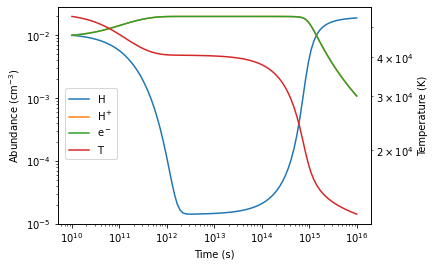

In [209]:
from simple_rhs import rhs_func
from scipy.integrate import odeint

timesteps = np.logspace(10, 16,101)
output     = odeint(rhs_func, state, t=timesteps)

H_1_traj, H_2_traj, de_traj, ge_traj = output.T

f, ax = plt.subplots()
l1= ax.loglog(timesteps, H_1_traj)
l2= ax.loglog(timesteps, H_2_traj)
l3= ax.loglog(timesteps, de_traj)
ax2 = ax.twinx()
T_traj = calculate_temperature(output.T)
l4= ax2.loglog(timesteps, T_traj, color='C3')


ax.set_ylabel(r"Abundance ($\rm cm^{-3}$)")
ax2.set_ylabel("Temperature (K)")

ax.set_xlabel("Time (s)")

f.legend(
    [l1,l2,l3,l4], 
    labels=[r'$\rm H$',r'$\rm H^+$',r'$\rm e^-$',r'$\rm T$'],
    loc=[0.15,0.4]
)
plt.subplots_adjust(right=0.85)

In [193]:
solver_rhs_template = Template("""
import h5py
import numpy as np
gamma = 5./3.
kb    = 1.38e-16
mh    = 1.67e-24


# read rates in as global variables
rates_table = "{{solver_name}}_tables.h5"
ratef = h5py.File(rates_table, 'r')

# Reaction Rates
{% for k in network.reactions.keys()%}
out{{k}}dev = ratef['{{k}}'][:]
{%- endfor %} 

# Cooling Rates
{%- for name, rate in network.cooling_actions | dictsort %}
{%- for name2 in rate.tables | sort %}
out_{{name}}_{{name2}} = ratef["{{name}}_{{name2}}"][:]
{%- endfor %}
{%- endfor %}
tdev = ratef['T'][:]
ratef.close()

def interpolate_rates(T):
    {% for k in network.reactions.keys()%}
    {{k}} = np.interp(T, tdev, out{{k}}dev)
    {%- endfor %} 
    return (
    {%- for k in network.reactions.keys() -%}
    {{k}}, 
    {%- endfor -%}
    )
def interpolate_cooling_rates(T):
    {%- for name, rate in network.cooling_actions | dictsort %}
    {%- for name2 in rate.tables | sort %}
    {{name}}_{{name2}} = np.interp(T, tdev, out_{{name}}_{{name2}})
    {%- endfor %}
    {%- endfor %}
    return (
    {%- for name, rate in network.cooling_actions | dictsort -%}
    {%- for name2 in rate.tables | sort -%}
    {{name}}_{{name2}}, 
    {%- endfor -%}
    {%- endfor -%}
    )


def calculate_temperature(state):
    # extract the abundance from the state vector
    {% for s in network.required_species | sort -%}
    {{s.name}}, 
    {%- endfor -%}
    = state
    density = {{network.print_mass_density()}}
    T = {{network.temperature_calculation()}}
    return T
    
def rhs_func(state, t):

    # extract the abundance from the state vector
    {% for s in network.required_species | sort -%}
    {{s.name}}, 
    {%- endfor -%}
    = state
    
    T   = calculate_temperature(state)[np.newaxis]
    
    {% for k in network.reactions.keys() -%}
    {{k}}, 
    {%- endfor -%}
    = interpolate_rates    (T)
    
    i = 0
    
    {% for name, rate in network.cooling_actions | dictsort -%}
    {%- for name2 in rate.tables | sort -%}
    {{name}}_{{name2}}, 
    {%- endfor -%}
    {%- endfor -%}
    = interpolate_cooling_rates(T)
    
    rho = {{network.print_mass_density()}}
    
    {% for s in network.required_species | sort %}
    {% if s.name != "ge" %}
    d{{s.name}}dt = {{network.species_total(s)}}
    {% else %}
    d{{s.name}}dt = {{network.print_cooling(assign_to=None)}} / mh/ rho
    {%- endif -%}
    {%- endfor %}
    
    return {% for s in network.required_species | sort -%}
    d{{s.name}}dt, 
    {%- endfor -%}
""")

output_file = f'{solver_name}_solver.py'
with open(output_file, 'w') as f:
    f.write(solver_rhs_template.render(template_vars))

In [194]:
from simple_solver import rhs_func

/tmp/ipykernel_6081/2565928376.py:20: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  f.legend(


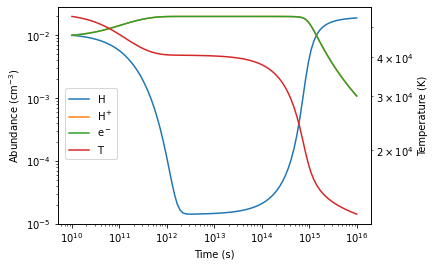

In [195]:
timesteps = np.logspace(10, 16,101)
output     = odeint(rhs_func, state, t=timesteps)

H_1_traj, H_2_traj, de_traj, ge_traj = output.T

f, ax = plt.subplots()
l1= ax.loglog(timesteps, H_1_traj)
l2= ax.loglog(timesteps, H_2_traj)
l3= ax.loglog(timesteps, de_traj)
ax2 = ax.twinx()
T_traj = calculate_temperature(output.T)
l4= ax2.loglog(timesteps, T_traj, color='C3')


ax.set_ylabel(r"Abundance ($\rm cm^{-3}$)")
ax2.set_ylabel("Temperature (K)")

ax.set_xlabel("Time (s)")

f.legend(
    [l1,l2,l3,l4], 
    labels=[r'$\rm H$',r'$\rm H^+$',r'$\rm e^-$',r'$\rm T$'],
    loc=[0.15,0.4]
)
plt.subplots_adjust(right=0.85)

### Yay! you have learnt how to write a Jinja2 template from scratch
this template is also available under `dengo/templates/scipy/dengo_rhs.py.template`. While we only demonstrated it with a 2 species model with 2 reactions and 1 cooling action. This would still work for any user-specied network!

The workflow we outlined in this chapter works for a simple prototyping with `scipy.integrate.odeint`. To extend it to more efficient deployments with `C` libraries and the ODE solver `SUNDIALS CVODE` in massively parallel setting, we have also provide our template function for generating compilable C-libraries under `dengo/templates/`. This will be introduced in the next chapter.